In [8]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
fred = Fred(api_key='YOURAPIKEYHERE')

# 1. Dicky-fuller test

In [9]:
# Dickey-Full
from statsmodels.tsa.stattools import adfuller

def dick_full(array):
    adf = adfuller(array)
    print("Dickey-fuller p-value: {:.4f}".format(adf[1]))
    if adf[1]<.05:
        print('We can reject the null hypothesis')
        print('Thus this series is stationary')
    else:
        print('We cannot reject the null hypothesis')
        print('Thus this series is NOT stationary')
    
    plt.plot(array)
    if adf[1]<.05:
        plt.title('Stationary: DF-P-value={:.3f}'.format(adf[1]))
    else:
        plt.title('NOT Stationary: DickeyFuller P-value={:.3f}'.format(adf[1]))

# 2. GDP growth
- Quarterly from FRED
- https://fred.stlouisfed.org/series/JPNNGDP


In [10]:
gdp = fred.get_series('JPNNGDP').to_frame()
gdp.tail(2)

,0
2019-07-01,558237.1
2019-10-01,549920.9


Dickey-fuller p-value: 0.5138
We cannot reject the null hypothesis
Thus this series is NOT stationary


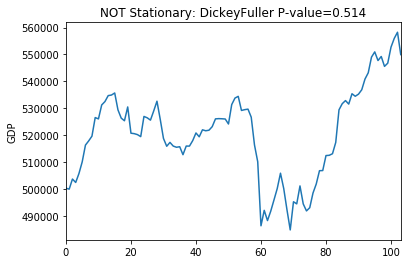

In [11]:
ax = dick_full(gdp.values.ravel())
plt.ylabel('GDP')
plt.margins(x=0)

# 3. Cross border claims

In [15]:
filename = 'Data/Cross_border.xlsx'
df = pd.read_excel(filename)
#Drop uncessary columns
df= df.iloc[:, 13:]
df.head(1)

,Counterparty sector,Balance sheet position,31/12/1977,31/03/1978,30/06/1978,30/09/1978,31/12/1978,31/03/1979,30/06/1979,30/09/1979,...,31/03/2017,30/06/2017,30/09/2017,31/12/2017,31/03/2018,30/06/2018,30/09/2018,31/12/2018,31/03/2019,30/06/2019
0,A:All sectors,C:Total claims,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4488320.705,4398581.592,4516378.685,4593028.307,4709549.57,4542318.193,4573937.437,4647940.491,4852249.8,4769612.376


In [17]:
cross = df.melt(
    id_vars = ['Counterparty sector', 'Balance sheet position'], #Variables 
      var_name='Date', value_name='Value')
cross.Date = pd.to_datetime(cross.Date)
cross = cross.set_index('Date')
cross.head(2)

,Counterparty sector,Balance sheet position,Value
Date,,,
1977-12-31,A:All sectors,C:Total claims,NaN
1977-12-31,A:All sectors,L:Total liabilities,NaN


# 4. Cointegration

## 4.1 By hand

In [18]:
nonbanks = (cross['Counterparty sector']== 'N:Non-banks, total') & (cross['Balance sheet position']=='C:Total claims')
x = cross[nonbanks].loc['1995':, ['Value']].astype(float)
y = gdp['1995-04':].astype(float)
x =np.array(x, dtype='float')
y = np.array(y, dtype='float')[:-1]
len(x)==len(y)

True

In [19]:
import statsmodels.api as sm
result = sm.OLS(y, x).fit()

- Cointegration involves two steps: regressing one time series on the other to get the cointegration vector, and then perform an ADF test on the residuals of the regression.

In [20]:
b = result.params[0]
test = (y-(b*x))
adf_stats = adfuller(test.ravel())
print("The p-value for the ADF test is ", adf_stats[1])

The p-value for the ADF test is  0.9705159073822973


## 4.2 Statsmodels

The Null hypothesis is that there is no cointegration, the alternative hypothesis is that there is cointegrating relationship. If the pvalue is small, below a critical size, then we can reject the hypothesis that there is no cointegrating relationship.

P-values and critical values are obtained through regression surface approximation from MacKinnon 1994 and 2010.

In [21]:
from statsmodels.tsa.stattools import coint

In [22]:
if coint(y,x, autolag='BIC')[1]>.05:
    print('P-value {:.3f}'.format(coint(y,x, autolag='BIC')[1]))
    print('Cannot reject null of no cointegration')
else:
    print('P-value {:.3f}'.format(coint(y,x, autolag='BIC')[1]))
    print('We can reject the null of no cointegration')
    print('Thus we have evidence of cointegration')

P-value 0.934
Cannot reject null of no cointegration


# 5. VECM


## 5.1 Johansen
https://www.statsmodels.org/stable/generated/statsmodels.tsa.vector_ar.vecm.coint_johansen.html#statsmodels.tsa.vector_ar.vecm.coint_johansen

In [23]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

In [24]:
data = np.concatenate([x,y], axis=1)
jh_results= coint_johansen(data, 1, 1)

#print(f'Trace: {jh.lr1}')                           # dim = (n,) Trace statistic
print(f'Critical values trace: {jh_results.cvt}')                           # dim = (n,3) critical value table (90%, 95%, 99%)
#print(f'Columnwise eigen vectors: {jh.evec}')                          # dim = (n, n), columnwise eigen-vectors
#print(f'Critical values for max eigenvalue stat: {jh.cvm}')
#print(f'Critical values max eigen: {jh_results.cvm}') 

Critical values trace: [[16.1619 18.3985 23.1485]
 [ 2.7055  3.8415  6.6349]]


## 5.2 Selecting coint rank 
- select_coint_rank
- https://www.statsmodels.org/stable/generated/statsmodels.tsa.vector_ar.vecm.select_coint_rank.html#statsmodels.tsa.vector_ar.vecm.select_coint_rank

In [25]:
from statsmodels.tsa.vector_ar.vecm import select_coint_rank as sr

In [26]:
print(sr(data, 1, k_ar_diff=1, method='trace'))

Johansen cointegration test using trace test statistic with 5% significance level
r_0 r_1 test statistic critical value
-------------------------------------
  0   2          5.286          18.40
-------------------------------------


- select order
- https://www.statsmodels.org/stable/generated/statsmodels.tsa.vector_ar.vecm.select_order.html#statsmodels.tsa.vector_ar.vecm.select_order

In [27]:
from statsmodels.tsa.vector_ar.vecm import select_order as so

In [28]:
print(so(data, maxlags=5, deterministic='li'))

<statsmodels.tsa.vector_ar.var_model.LagOrderResults object. Selected orders are: AIC -> 3, BIC -> 0, FPE -> 3, HQIC -> 0>


## 5.3 VECM results

In [29]:
from statsmodels.tsa.vector_ar.vecm import VECM

In [30]:
result = VECM(data).fit()

In [31]:
result.summary()

,coef,std err,z,P>|z|,[0.025,0.975]
L1.y1,-0.1909,0.100,-1.911,0.056,-0.387,0.005
L1.y2,2.6908,1.415,1.902,0.057,-0.082,5.464
,coef,std err,z,P>|z|,[0.025,0.975]
L1.y1,0.0090,0.007,1.274,0.203,-0.005,0.023
L1.y2,0.1230,0.100,1.224,0.221,-0.074,0.320
,coef,std err,z,P>|z|,[0.025,0.975]
ec1,0.0065,0.001,4.392,0.000,0.004,0.009
,coef,std err,z,P>|z|,[0.025,0.975]
ec1,3.592e-05,0.000,0.341,0.733,-0.000,0.000
,coef,std err,z,P>|z|,[0.025,0.975]
